<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 27 - Introduction to Volume, Slippage, and Liquidity
***

# Introduction to Volume, Slippage, and Liquidity
by Delaney Mackenzie and Maxwell Margenot

## What is Volume?
Volume is how much trading occurs for a given instrument, or set of instruments, over a given time period. 

### Example Volume Computation
For instance, consider a hypothetical equity asset $A$. If, over the course of a minute, $100,000$ shares of $A$ are bought, then the shares traded volume of $A$ is $100,000$. To find the dollar volume traded for $A$, which is the more often-used statistic, we need to take a weighted average of all the different prices $A$ traded for over the minute times the number of shares that traded at each price. This is equivalent to adding up the dollar volumes of all the individual trasnactions that occured. For instance, let's say in this case there were there separate transactions. One for 30,000 shares, one for $60,000$ shares, and one for $10,000$ shares. The prices were $30$ USD, $31$ USD, and $33$ USD, respectively. Let's model this out.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
num_shares = np.asarray([30000, 60000, 10000])
prices = np.asarray([30, 31, 33])

np.dot(num_shares, prices)

3090000

So total dollar volume is $3.09$ million USD. Notice that this is equivalent to taking the dollar volume averaged price and multiplying by the number of shares traded over that bar.

In [3]:
# Get the average trade price
print("Average trade price: %s" % (np.mean(prices)))

# Get the volume weighted average
vw = np.dot(num_shares, prices) / float(np.sum(num_shares))
print("Volume weighted average trade price: %s" % (vw))

# Go back to volume
v = vw * np.sum(num_shares)
print("Volume: %s" % (v))

Average trade price: 31.333333333333332
Volume weighted average trade price: 30.9
Volume: 3090000.0


Often in real datasets you will be given averaged or 'last traded' data rather than individual trades. With averaged data, some average is taken over a bar (time period). With last traded data, only the final observation from that bar is reported. It is important to know if the data is averaged, volume averaged, or simply last traded. All of these will need to be treated differently.

For pricing data, QuantRocket's US Stock dataset provides the last traded prices at a minute resolution. The volume is the sum of all volume in that bar. While we do not offer minutely volume-weighted price, daily volume-weighted price can be approximated from the minute bars.

Let's look at some volume data.

In [4]:
from quantrocket.master import get_securities
from quantrocket import get_prices

securities = get_securities(symbols='SPY', vendors='usstock')
SPY = securities.index[0]
data = get_prices('usstock-free-1min', sids=SPY, data_frequency='minute', start_date='2015-06-01', end_date='2015-06-20', fields='Volume')
volume = data.loc['Volume'][SPY]

volume.head()

Date        Time    
2015-06-01  09:30:00    1622342.0
            09:31:00     874752.0
            09:32:00     487747.0
            09:33:00     311191.0
            09:34:00     430144.0
Name: FIBBG000BDTBL9, dtype: float64

Notice that just plotting the volume gives us lots of gaps. This is because we are plotting data with time on the x-axis, and equities are only traded during part of the day. The rest of the day we have no data for volume. There is a small amount of overnight trading that occurs for equities, but it is often only useful as a data source as the liquidity is too low to trade. The US Stock dataset does not provide data on overnight trading, just for regular market hours.

In [5]:
# Combine separate Date and Time in index into datetime
volume.index = pd.to_datetime(volume.index.get_level_values('Date').astype(str) + ' ' + volume.index.get_level_values('Time'))

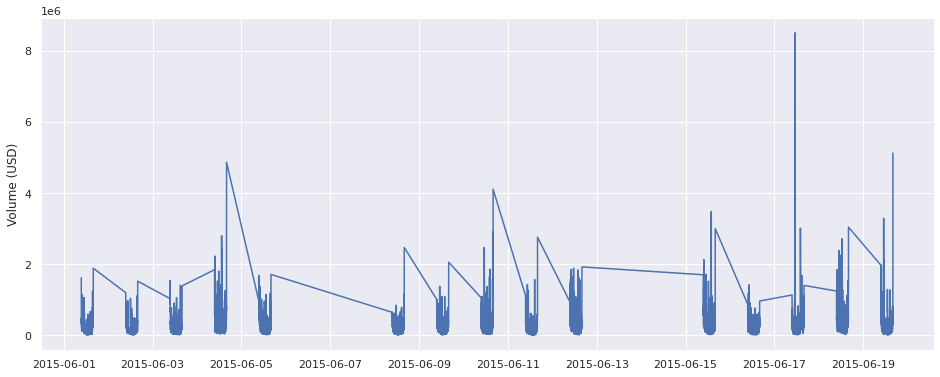

In [6]:
plt.plot(volume)
plt.ylabel('Volume (USD)');

Let's look at how this volume is balanced out over a single day.

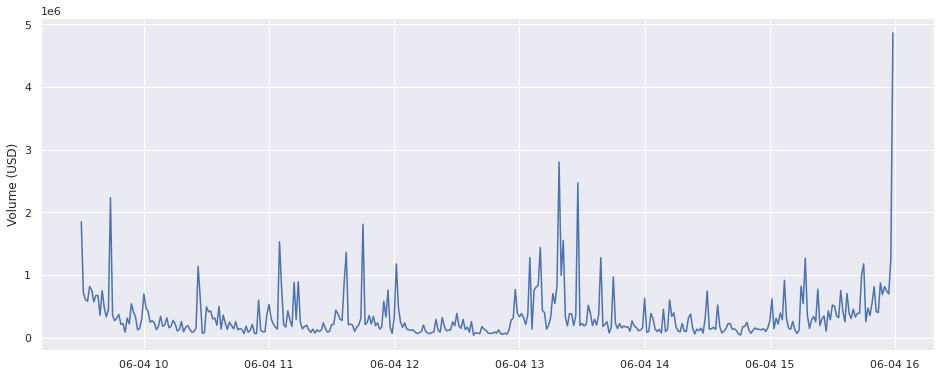

In [7]:
plt.plot(volume['2015-06-04'])
plt.ylabel('Volume (USD)');

This is pretty noisy, but with pandas we can easily take an average across all the days in our sample to get a sense of how volume fluctuates on average. Here is the average volume for a given minute over the whole time period.

In [8]:
avg_minute_volume = volume.groupby([volume.index.hour, volume.index.minute]).mean()

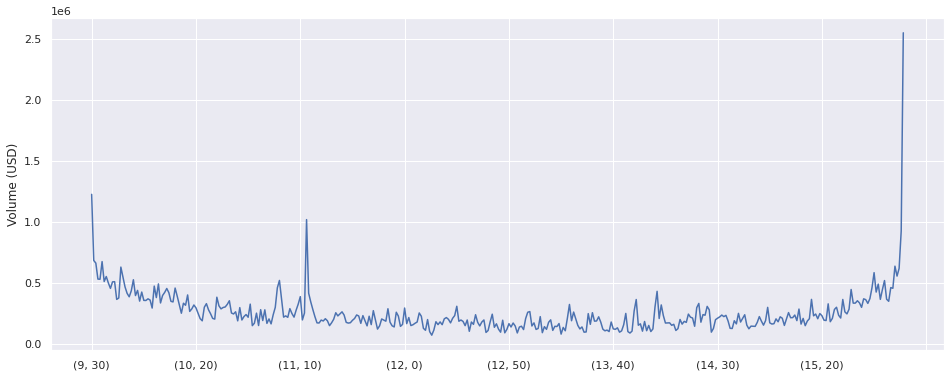

In [9]:
avg_minute_volume.plot()
plt.ylabel('Volume (USD)');

### High Equity Volume After Market Open
There tends to be high volume right after market open. This is due to a variety of factors including people wanting to update their positions based on price changes and new information that emerged before trading started. Since there was a ton of time and possibly news overnight while the market could not react, trading right after the open can be a bit volatile as pricing adjusts.

### High Equity Volume Before Market Close
There is a similar effect at the end of the day when people want to get in their final orders before trading closes and they no longer have the chance. Again there are a variety of factors that drive this increase, but the effect tends to be consistent.

### Modeling Volume
Volume can change a lot, and summary statistics such as mean volume may not always be representative. Model it as you would any other quantity and pay attention to whether your volume forecasts or measurements are useful. We do not discuss any specific models in this lecture as the models are often specific to the markets and instruments being traded.

As with any other model, a model of volume needs to be carefully validated using rigorous statistics. As a rule of thumb you can expect more volume at the start and end of day in the US Equity market, but this will vary by equity and day, plus there will be shocks and half days. In practice you should apply just as much care as you would trying to model returns.  

## What is Slippage?
Slippage occurs when large buy or sell orders drive the price of the market up or down respectively. Remember that for every share bought, a share must be sold by another party. If no parties are selling shares, buy orders will not be filled. This is a simplification of what actually occurs as there are complexities around issues such as bid/ask spread, but we will not consider those here. To understand why price shifts happen when large orders are placed, consider the following scenario:

1. Person A places a buy order for $1000$ shares of stock X. Currently trading at $100$ USD / share.
2. There is only one sell order for $500$ shares.
3. The broker fills $500$ shares of the order at $100$ USD / share.
3. There are $500$ shares remaining to fill. Other market participants notice that there is demand at $100$ USD / share, so they increase their sell price to $101$ USD / share.
4. Another sell order gets placed for $500$ shares at $101$ USD / share.
5. The broker fills the remaining $500$ shares of the original order at $101$ USD / share. Closing out the process.

As you can see, the large order for stock X was not immediately filled, and the demand pushed the market price against the original order, resulting in a fill price worse than expected. The opposite occurs for sell orders. In general, the larger the order, the more slippage will be experienced by a trade.

### Complications with Forecasting Slippage
Modeling slippage is not trivial and is the subject of research by professional quantitative teams. There are different parameters and the behavior of slippage varies across markets and instruments. Things like the bid/ask spread will influence it.


### Why is this Important to Quantitative Strategies?
Quantitative strategies often rely on finding small but consistent edges across many instruments in a market or multiple markets. If the amount of profit you expect to make off of each trade is very small, slippage can eat a significant amount of that profit. Quantitative strategies rely on executing orders as they have been defined, so anything that counteracts the orders can break the strategy.


### Where is Slippage Worst?
Slippage is often worst on stocks with very little volume. Some egregious offenders are small and micro cap stocks. They are very low volume and develop large inefficiencies, but when you try to trade the inefficiencies you are unable to due to the lack of trades on the other side of the market. If you wait long enough you may be able to fill your order, but in that time you will suffer a lot of slippage.

## What is Liquidity?
Before we can define liquidity, we need to define a few key execution parameters. This is certainly not an exhaustive list of parameters that can decribe execution conditions, but they are the key ones for our purposes here.

### Execution Parameters
* Trade Size $s$
* Market Price $p_m$
* Time to Fill $t$
* Realized Fill Price $p_f$

### Defining Liquidity in Terms of Execution Feasibility
Liquidity is a somewhat ambiguous term. There are different ways of defining it and therefore different ways of measuring it. In general it's the ability to execute large trades quickly without experiencing slippage. Another way to think about it is how easy it is to convert a held asset to cash quickly. Rather than having one precise definition, people often descibe liquidity according to their trading needs. For instance, if one regularly needs to execute trades of size $s$=100,000USD, and market $M_1$ can regularly support that with fills coming within $t$=1s and slippage or $p_f / p_m$ < 1.0001 (0.01% error), then we'd say that market $M$ is sufficiently liquid for one's purposes. On the other hand if another market $M_2$ can support trades of larger size, fill them in shorter time, or has consistently less slippage, then we would say that $M_2$ is *more* liquid.

The takeaway is that liquidity depends on what you are trying to trade and how, and once you've established a benchmark you can compare it to other potential instruments, markets, brokers, or trading methods.

## Liquidity vs. Volume
Liquidity and volume are not the same thing. Liquidity is the important property that affects how easily we can trade. Volume is a related but indirect proxy for liquidity. In general people use volume as one of the main ways to determine how liquid a trading environemnt will be. If there is high volume, it's likely you'll be able to execute a trade quickly and with minimal slippage. If you're a high percentage of the volume, then you're in trouble. In general the higher the volume, the lower your percentage and the better things will be.

Although volume is central to liquidity, one can have cases of high volume with low liquidity.

### One-Sided Market
A market may have high volume, but with a lot of demand in one direction. This can occur during a panic event in which case many people want to sell. This can result in large bid-ask spreads and, while trades may be closing, they will be closing at prices far away from what you would like (AKA high slippage). The high slippage indicates that this is an illiquid market. It is also more difficult to determine a fair market price when spreads and volatility are high. Momentum strategies can have higher slippage due to the fact that you're jumping into the same side of the market as everybody else.

### Non-Continuous Prices
Sometimes there can be large block transactions occuring in a single instrument. Imagine that a large shareholder is trying to get rid of their stake in a company. Rather than selling it on the open market and exposing themselves to a massive amount of slippage, they trade it through other routes. There will still be a large amount of trading volume, but because it's not accessible to you, any trades you place will be exposed to the same illiquid conditions as without that volume.

## Transaction Costs
Whenever a trade is placed, you will pay a fee to the broker to trade. This fee can be based on trade size or just be flat, but is well defined and not an uncertain quantity. You will also experience slippage, which can be thought of as just another cost. Often both broker fees and slippage costs will be grouped under the term 'Transaction Costs', which describes generally how much it will cost to trade a specific strategy. If transaction costs eat too much of your profits a strategy might become infeasible.

### Transaction Costs Vary by Broker and Market
Because transaction costs vary based on trading environments, strategies that are not viable on a retail brokerage may be viable on an institutional prime brokerage with lower costs. Often quant strategies will fail on retail fees, but be fine for an institution. Just because you can't trade a strategy doesn't mean it's not valuable. You may be able to sell it to an organization that can trade it.

## Why is liquidity important?
Why do we actually care about modeling, forecasting, and understanding liquidity?

#### It's a bottleneck to trading any strategy
The final step of implementing any trading strategy is actually trading it. If you have statistically verified a mathematical model and it's pumping out target positions, that's not useful unless you can turn those positions into reality by trading in the market. Liquidity essentially defines your ability to move from current positions to desired future positions. With low liquidity you will not be able to execute on desired trades and there will be large infidelities between your model's requests and your real positions.

#### There's no perfect case
You cannot completely eliminate liquidity concerns. Each instrument will have variable liquidity and there may be exogenous system shocks. As with any other quantity you can just model it and then try to trade instruments for which you expect good liquidity. Every strategy will have some liquidity drag during actual trading, but you can just try to make it as small as possible by avoiding instruments with high liquidity risk.

#### Capital Base vs. Liquidity
The more capital you trade, the harder it is to fill trades without experiencing slippage, so the more expensive your trading will be. In general all strategies have capital ranges in which they are profitable. The upper limit is defined by liquidity constraints. Once you become too large a part of the market the slippage will eat all your returns. The lower end is defined by broker comissions and position errors. If you're attempting to trade a small amount of capital, flat trading costs from your broker may exceed returns. Likewise, if you are trading 100,000USD and place 1% of your portfolio into a single stock, you will not be able to buy precisely 100USD worth of the stock. The lack of fractional shares will result in large portfolio infidelities from your desired positions. Because trading few instruments results in position concentration risk, trading small amounts of capital is often difficult.

## Backtesting and Liquidity
The purpose of backtesting is not to determine whether a model has predictive power. That should all be done at the statistical analysis stage and is inefficient to do in a backtester, not to mention the overfitting risk.

The purpose of backtesting is to check how robust a strategy is to real market frictions like illiquidity, slippage, and the resulting transaction costs. You can have highly predictive models that are simply not tradeable because the underlying instruments are not liquid enough.

### Backtest Under a Range of Liquidity Assumptions
It pays to backtest under a few different liquidity assumptions. This tells you whether your strategy is robust, or whether it will fall apart the moment you change liquidity conditions at all.

## Broad Liquidity Considerations in Equities
* Liquidity will vary by market cap. Higher cap stocks experience more absolute trading volume and are more liquid. Micro-cap stocks are less liquid.
* Some stocks are hard to borrow/short, and may experience one sided liquidity. Longs are easy to purchase, but shorts are hard to obtain.

## Avoiding Illiquidity

#### Use a good universe

Start by defining a universe of liquid stocks, as covered in more detail in the Universe Selection lecture.


#### Execution Algorithms

Algorithms exist that try to time orders and parcel them out into smaller chunks across many markets or timeframes. These algorithms are collectively known as execution algorithms and aim to reduce issues with slippage and liquidity. We will not go into execution algorithms in this lecture, but they are the subject of a huge amount of industry and academic research. Often firms will have a quantitative research team dedicated to developing strategies, and another dedicated to researching ways to execute the trades.

---

**Next Lecture:** [Market Impact Models](Lecture28-Market-Impact-Models.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*